## Read sample COCO img

In [1]:
import cv2
import IPython

In [2]:
# if input image is in range 0..1, please first multiply img by 255
# assume image is ndarray of shape [height, width, channels] where channels can be 1, 3 or 4
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
img = cv2.imread('000000000001.jpg')

## Load same faster rcnn model as in VAS, run prediction on img

In [4]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

import torch

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

model = build_model(cfg).eval()

DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

outputs = model(torch.from_numpy(img).permute(2,0,1).unsqueeze(0))

In [6]:
img.shape, torch.from_numpy(img).permute(2,0,1).shape

((480, 640, 3), torch.Size([3, 480, 640]))

In [7]:
outputs[0]['instances'][0].pred_classes[0]

tensor(7, device='cuda:0')

In [8]:
outputs[0]['instances']

Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
        [  0.0000, 127.5443, 461.2285, 313.6560],
        [257.9050, 154.3555, 294.1206, 234.5074],
        [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
       grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
       grad_fn=<IndexBackward>), class_scores: tensor([[1.6389e-06, 2.7276e-08, 3.5390e-03, 6.9704e-07, 4.8906e-07, 1.0633e-04,
         9.6680e-07, 9.9403e-01, 1.6490e-06, 5.4901e-08, 2.9462e-08, 7.4964e-08,
         3.9216e-08, 1.3815e-06, 4.1913e-10, 5.6693e-09, 2.3887e-08, 1.6898e-08,
         3.2958e-08, 7.4388e-07, 1.5813e-07, 6.7380e-08, 2.0647e-08, 1.8330e-08,
         2.4201e-08, 3.6618e-08, 4.4246e-08, 2.7092e-09, 5.1305e-07, 3.4335e-09,
         1.3317e-08, 5.3220e-09, 3.3238e-09, 5.4561e-08, 7.0218e-09, 3.6462e-09,
         3.3209e-08, 1.2701e-08, 5.2054e-09, 2.1764e-08, 4.49

In [9]:
outputs[0]['instances'].pred_boxes.tensor.cpu().detach().int().numpy()

array([[268,  10, 635, 217],
       [  0, 127, 461, 313],
       [257, 154, 294, 234],
       [207, 111, 273, 135]], dtype=int32)

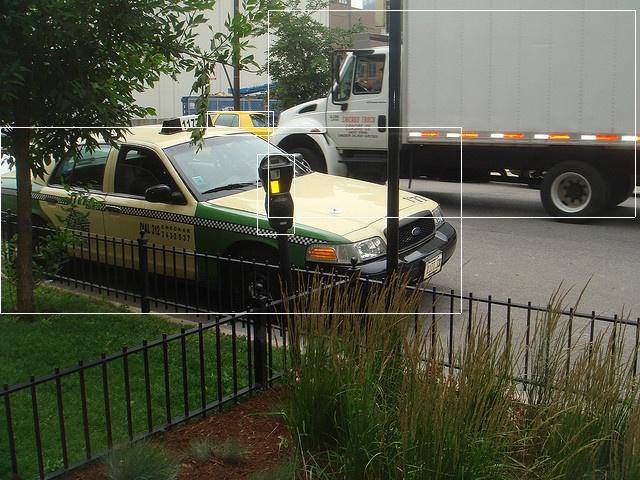

In [10]:
import numpy as np

clone = img.copy()

for box in outputs[0]['instances'].pred_boxes.tensor.cpu().detach().int().numpy():
    x0, y0, x1, y1 = box
    clone[y0:y1, x0] = np.full((y1-y0, 3), 255)
    clone[y0:y1, x1] = np.full((y1-y0, 3), 255)
    clone[y0, x0:x1] = np.full((x1-x0, 3), 255)
    clone[y1, x0:x1] = np.full((x1-x0, 3), 255)

imshow(clone)

### Visualise output

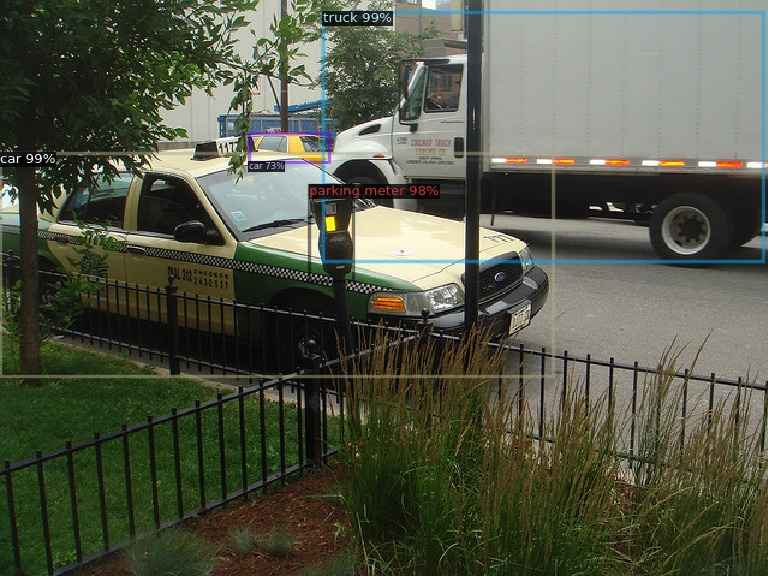

In [11]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
imshow(out.get_image()[:, :, ::-1])

## Partially executing faster rcnn

In [12]:
model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

### Feature extraction

In [13]:
input_img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float().to("cuda")

images = model.preprocess_image(input_img)

# features
features = model.backbone(images.tensor)

In [14]:
features.keys()

dict_keys(['p2', 'p3', 'p4', 'p5', 'p6'])

In [15]:
features['p2'].shape, features['p6'].shape

(torch.Size([1, 256, 120, 160]), torch.Size([1, 256, 8, 10]))

#### Global Average Pool feature maps

In [16]:
m = torch.nn.AvgPool3d(features['p2'].shape[1:])
print(m(features['p2'])[0, 0, 0, 0])
m = torch.nn.AvgPool3d(features['p6'].shape[1:])
print(m(features['p6'])[0, 0, 0, 0])

tensor(0.1130, device='cuda:0', grad_fn=<SelectBackward>)
tensor(-0.0325, device='cuda:0', grad_fn=<SelectBackward>)


### Features to RPN proposals

In [17]:
pred_objectness_logits, pred_anchor_deltas = model.proposal_generator.rpn_head([features[f] for f in cfg.MODEL.RPN.IN_FEATURES])

In [18]:
pred_objectness_logits[0].shape, pred_objectness_logits[4].shape

(torch.Size([1, 3, 120, 160]), torch.Size([1, 3, 8, 10]))

In [19]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

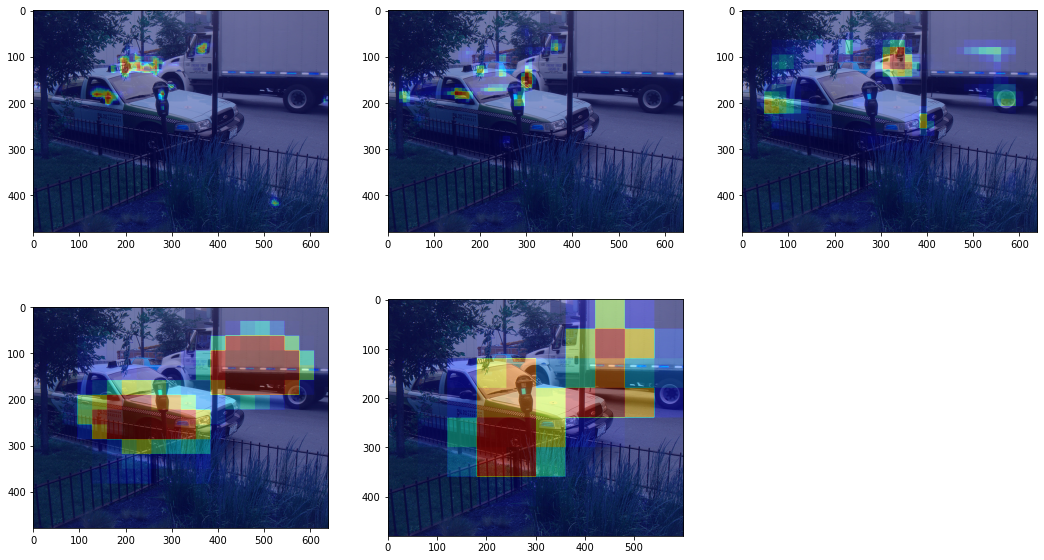

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2, 3))

for i in range(len(pred_objectness_logits)):
    heatmap = (pred_objectness_logits[i]
               .permute(0, 2, 3, 1)
               .cpu().detach()
               .apply_(sigmoid)[0,:,:,1])
                # 3 types of boxes, 1 is square, or 1:1 boxes
    fig.add_subplot(2, 3, i+1)
    plt.imshow(img)
    scale = int(img.shape[0]/heatmap.shape[0])
    plt.imshow(np.kron(heatmap, np.ones((scale, scale))), cmap=plt.get_cmap('jet'), alpha=0.4)
    
fig.set_size_inches(18, 10)

### Proposal Generator

In [21]:
# proposals
proposals, losses = model.proposal_generator(images, features)

In [22]:
model.proposal_generator

RPN(
  (rpn_head): StandardRPNHead(
    (conv): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation): ReLU()
    )
    (objectness_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (anchor_deltas): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (anchor_generator): DefaultAnchorGenerator(
    (cell_anchors): BufferList()
  )
)

In [23]:
proposals[0] # proposal_boxes, objectness_logits

Instances(num_instances=1000, image_height=480, image_width=640, fields=[proposal_boxes: Boxes(tensor([[268.6434,  17.7036, 620.5053, 207.9765],
        [  0.0000, 124.2298, 427.2461, 312.1107],
        [205.9015, 111.1070, 267.0046, 133.2463],
        ...,
        [ 93.3901, 130.8735, 210.4593, 170.2447],
        [161.0223, 151.4704, 254.1312, 194.8650],
        [369.4384,   1.7123, 617.6533, 121.0003]], device='cuda:0')), objectness_logits: tensor([ 1.1344e+01,  9.7688e+00,  8.2759e+00,  7.3148e+00,  6.6445e+00,
         6.5665e+00,  6.3424e+00,  6.0539e+00,  5.9940e+00,  5.8645e+00,
         5.2121e+00,  5.0507e+00,  4.8596e+00,  4.7841e+00,  4.7269e+00,
         4.6206e+00,  4.0945e+00,  3.9716e+00,  3.9232e+00,  3.9122e+00,
         3.9017e+00,  3.8732e+00,  3.8257e+00,  3.8139e+00,  3.7936e+00,
         3.7030e+00,  3.6618e+00,  3.5700e+00,  3.4927e+00,  3.4452e+00,
         3.3353e+00,  3.3274e+00,  3.2691e+00,  3.2594e+00,  3.2552e+00,
         3.2178e+00,  3.2176e+00,  3.2163e

In [24]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

objectness_scores = proposals[0].objectness_logits.cpu().apply_(sigmoid)

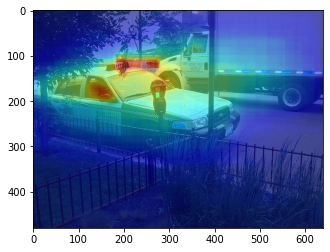

In [25]:
import numpy as np
import matplotlib.pyplot as plt

clone = np.zeros(img.shape[:2])
boxes = proposals[0].proposal_boxes.tensor.cpu().detach().int().numpy()

for i in range(len(boxes)):
    box = boxes[i]
    x0, y0, x1, y1 = box
    if x1 == 640:
        x1 -= 1
    if y1 == 480:
        y1 -= 1
    clone[y0:y1, x0:x1] += np.full((y1-y0, x1-x0), objectness_scores[i])
    
plt.imshow(img)
plt.imshow(clone, cmap=plt.get_cmap('jet'), alpha=0.5)

### ROI

In [47]:
type(model.roi_heads)

detectron2.modeling.roi_heads.roi_heads.StandardROIHeads

In [27]:
features_list = [features[f] for f in model.roi_heads.box_in_features]
model.roi_heads.box_in_features, features.keys() # note the missing 'p6' from features.keys()

(['p2', 'p3', 'p4', 'p5'], dict_keys(['p2', 'p3', 'p4', 'p5', 'p6']))

In [28]:
box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
box_features.shape

torch.Size([1000, 256, 7, 7])

#### Some examples of cropped ROI

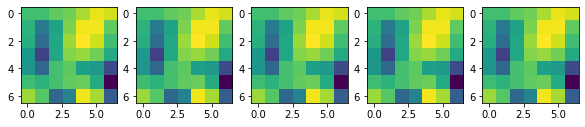

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(1, 5))

for i in range(5):
    cropped_roi = torch.sum(box_features[0].cpu().detach(), dim=0)
    fig.add_subplot(1, 5, i+1)
    plt.imshow(cropped_roi)
    
fig.set_size_inches(10, 5)

#### Flatten cropped ROI

In [30]:
model.roi_heads.box_head

FastRCNNConvFCHead(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc_relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_relu2): ReLU()
)

In [31]:
box_features2 = model.roi_heads.box_head(box_features)
box_features2, box_features2.shape

(tensor([[0.0000, 1.7541, 0.0000,  ..., 1.0968, 0.2279, 1.3410],
         [0.0000, 0.5137, 0.0000,  ..., 0.2092, 0.0000, 1.2763],
         [0.0000, 0.9075, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 1.3037, 0.5984,  ..., 0.0000, 0.6203, 0.0000],
         [0.0000, 0.5645, 0.0264,  ..., 0.3278, 0.0000, 0.0000],
         [0.0000, 1.8422, 0.0000,  ..., 2.0580, 0.0000, 0.0022]],
        device='cuda:0', grad_fn=<ReluBackward0>),
 torch.Size([1000, 1024]))

#### Convert flattened and linear layers to class scores and proposal deltas

In [51]:
model.roi_heads.box_predictor.cls_score.in_features

1024

In [33]:
scores, proposal_deltas = predictions = model.roi_heads.box_predictor(box_features2)
scores.shape, proposal_deltas.shape

(torch.Size([1000, 81]), torch.Size([1000, 320]))

In [34]:
pred_instances, _ = model.roi_heads.box_predictor.inference(predictions, proposals)
pred_instances

[Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
         [  0.0000, 127.5443, 461.2285, 313.6560],
         [257.9050, 154.3555, 294.1206, 234.5074],
         [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
        grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
        grad_fn=<IndexBackward>), class_scores: tensor([[1.6389e-06, 2.7276e-08, 3.5390e-03, 6.9704e-07, 4.8906e-07, 1.0633e-04,
          9.6680e-07, 9.9403e-01, 1.6490e-06, 5.4901e-08, 2.9462e-08, 7.4964e-08,
          3.9216e-08, 1.3815e-06, 4.1913e-10, 5.6693e-09, 2.3887e-08, 1.6898e-08,
          3.2958e-08, 7.4388e-07, 1.5813e-07, 6.7380e-08, 2.0647e-08, 1.8330e-08,
          2.4201e-08, 3.6618e-08, 4.4246e-08, 2.7092e-09, 5.1305e-07, 3.4335e-09,
          1.3317e-08, 5.3220e-09, 3.3238e-09, 5.4561e-08, 7.0218e-09, 3.6462e-09,
          3.3209e-08, 1.2701e-08, 5.2054e-09, 2.17

#### Break down model.roi_heads.box_predictor.inference

In [35]:
'''
list[Tensor]:
A list of Tensors of predicted class-specific or class-agnostic boxes
for each image. Element i has shape (Ri, K * B) or (Ri, B), where Ri is
the number of proposals for image i and B is the box dimension (4 or 5)
'''
# basically converts proposal_deltas to actual bounding boxes
boxes = model.roi_heads.box_predictor.predict_boxes(predictions, proposals)
boxes[0].shape # per ROI, we have 80 class-specific bounding boxes

torch.Size([1000, 320])

In [36]:
'''
list[Tensor]:
A list of Tensors of predicted class probabilities for each image.
Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
'''
# basically F.softmax(scores, dim=-1) for all
scores = model.roi_heads.box_predictor.predict_probs(predictions, proposals)
scores[0].shape

torch.Size([1000, 81])

In [37]:
# len(proposals) = len(image_shapes) = 1
image_shapes = [x.image_size for x in proposals]
image_shapes

[(480, 640)]

In [38]:
from typing import Dict, List, Tuple, Union

def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float, # set by config, is 0.5 rn
    nms_thresh: float, # 0.5 by default
    topk_per_image: int, # 100 by default, but usually won't have that many detected objects in an image
):
    
    # result_per_image : list[(Instances, Tensor)]
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    
    # list[Instances], list[Tensor]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]

# TODO

Edit fast_rcnn_inference_single_image on jpnote to return array of instances with associated class probabilities DONE

Copy changes to subclass of detectron2.modeling.roi_heads.fast_rcnn.fast_rcnn_inference

### Think...

Should I subclass ModifiedGeneralizedRCNN some more to redifine fast_rcnn_inference_single_image?

In [39]:
from detectron2.structures import Boxes, Instances
from detectron2.layers import batched_nms

def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    """
    Single-image inference. Return bounding-box detection results by thresholding
    on scores and applying non-maximum suppression (NMS).
    """
    
    # sanity check that all values are finite, i.e. they are not NaN, negative infinity, or infinity
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]

    scores = scores[:, :-1] # drop last class as that is background (class 80)
    raw_scores = scores.detach().clone()    
    
    # total number of classes (80)
    num_bbox_reg_classes = boxes.shape[1] // 4
    
    # Convert to Boxes to use the `clip` function
    '''
    .reshape(-1, 4) to flatten out the 80 class-specific bounding boxes per ROI 
        into 80*NUM_ROI w NUM_ROI=1000 boxes
    '''
    boxes = Boxes(boxes.reshape(-1, 4)) 
    '''
    Clip (in place) the boxes by limiting x coordinates to the range [0, width]
        and y coordinates to the range [0, height].
    '''
    boxes.clip(image_shape)
    '''
    .view(-1, num_bbox_reg_classes, 4) to convert back to NUM_ROI * 80 * 4
    Somehow the order doesn't get mixed up lol works as expected :O
    '''
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)

    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K w R = 1000, K = 80
    
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    # R' <= R
    filter_inds = filter_mask.nonzero()
    
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask] # [R', 4]
        
    scores = scores[filter_mask] # [R']
    raw_scores = raw_scores[filter_inds[:,0]] # [R', K] w K = 80
    print(raw_scores.shape)

    # 2. Apply NMS for each class independently.
    keep = batched_nms(boxes, scores, filter_inds[:, 1], nms_thresh)
    
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
        # int64 tensor with the indices of the elements that 
        # have been kept by NMS, sorted in decreasing order of scores
        
    boxes, scores, filter_inds, raw_scores = boxes[keep], scores[keep], filter_inds[keep], raw_scores[keep]
    print(raw_scores.shape)

    # convert results into Instances
    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    result.raw_scores = raw_scores
    
    # Instances, Tensor
    return result, filter_inds[:, 0]

In [40]:
fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            score_thresh=0.5,
            nms_thresh=0.5,
            topk_per_image=10,
        )

torch.Size([70, 80])
torch.Size([4, 80])


([Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
          [  0.0000, 127.5443, 461.2285, 313.6560],
          [257.9050, 154.3555, 294.1206, 234.5074],
          [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
         grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
         grad_fn=<IndexBackward>), pred_classes: tensor([ 7,  2, 12,  2], device='cuda:0'), raw_scores: tensor([[1.6389e-06, 2.7276e-08, 3.5390e-03, 6.9704e-07, 4.8906e-07, 1.0633e-04,
           9.6680e-07, 9.9403e-01, 1.6490e-06, 5.4901e-08, 2.9462e-08, 7.4964e-08,
           3.9216e-08, 1.3815e-06, 4.1913e-10, 5.6693e-09, 2.3887e-08, 1.6898e-08,
           3.2958e-08, 7.4388e-07, 1.5813e-07, 6.7380e-08, 2.0647e-08, 1.8330e-08,
           2.4201e-08, 3.6618e-08, 4.4246e-08, 2.7092e-09, 5.1305e-07, 3.4335e-09,
           1.3317e-08, 5.3220e-09, 3.3238e-09, 5.4561e-08, 7.0218e-

Only step left is post processing, which does not change any of the values but just presents the data in a different manner.

### Compare

In [41]:
model._postprocess(pred_instances, input_img, images.image_sizes)

[{'instances': Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
          [  0.0000, 127.5443, 461.2285, 313.6560],
          [257.9050, 154.3555, 294.1206, 234.5074],
          [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
         grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
         grad_fn=<IndexBackward>), class_scores: tensor([[1.6389e-06, 2.7276e-08, 3.5390e-03, 6.9704e-07, 4.8906e-07, 1.0633e-04,
           9.6680e-07, 9.9403e-01, 1.6490e-06, 5.4901e-08, 2.9462e-08, 7.4964e-08,
           3.9216e-08, 1.3815e-06, 4.1913e-10, 5.6693e-09, 2.3887e-08, 1.6898e-08,
           3.2958e-08, 7.4388e-07, 1.5813e-07, 6.7380e-08, 2.0647e-08, 1.8330e-08,
           2.4201e-08, 3.6618e-08, 4.4246e-08, 2.7092e-09, 5.1305e-07, 3.4335e-09,
           1.3317e-08, 5.3220e-09, 3.3238e-09, 5.4561e-08, 7.0218e-09, 3.6462e-09,
           3.3209e-08, 1.2

In [42]:
outputs

[{'instances': Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[268.8124,  10.1531, 635.7438, 217.2254],
          [  0.0000, 127.5443, 461.2285, 313.6560],
          [257.9050, 154.3555, 294.1206, 234.5074],
          [207.1271, 111.1354, 273.8721, 135.3514]], device='cuda:0',
         grad_fn=<IndexBackward>)), scores: tensor([0.9940, 0.9885, 0.9784, 0.7326], device='cuda:0',
         grad_fn=<IndexBackward>), class_scores: tensor([[1.6389e-06, 2.7276e-08, 3.5390e-03, 6.9704e-07, 4.8906e-07, 1.0633e-04,
           9.6680e-07, 9.9403e-01, 1.6490e-06, 5.4901e-08, 2.9462e-08, 7.4964e-08,
           3.9216e-08, 1.3815e-06, 4.1913e-10, 5.6693e-09, 2.3887e-08, 1.6898e-08,
           3.2958e-08, 7.4388e-07, 1.5813e-07, 6.7380e-08, 2.0647e-08, 1.8330e-08,
           2.4201e-08, 3.6618e-08, 4.4246e-08, 2.7092e-09, 5.1305e-07, 3.4335e-09,
           1.3317e-08, 5.3220e-09, 3.3238e-09, 5.4561e-08, 7.0218e-09, 3.6462e-09,
           3.3209e-08, 1.2

## Captum

In [43]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

## Run on model

In [44]:
input_   = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)
baseline = torch.zeros(input_.shape)
baseline.shape

torch.Size([1, 3, 480, 640])

### Need input_/baseline to be tensor, model needs to take in individual tensor

In [45]:
def wrap(input_tensor):
    print(input_tensor.shape)
    outputs = model(input_tensor)
    print(outputs)
    return outputs[0]['instances'][selected_pred].pred_classes[0]

In [46]:
ig = IntegratedGradients(wrap)
attributions, delta = ig.attribute(input_, baseline, target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

torch.Size([50, 3, 480, 640])


RuntimeError: CUDA out of memory. Tried to allocate 938.00 MiB (GPU 0; 4.00 GiB total capacity; 2.23 GiB already allocated; 153.60 KiB free; 2.71 GiB reserved in total by PyTorch)

In [ ]:
gs = GradientShap(model)

# We define a distribution of baselines and draw `n_samples` from that
# distribution in order to estimate the expectations of gradients across all baselines
baseline_dist = torch.randn(5, 3, 480, 640) * 0.001
attributions, delta = gs.attribute(input_, stdevs=0.09, n_samples=4, baselines=baseline_dist,
                                   target=0, return_convergence_delta=True)
print('GradientShap Attributions:', attributions)
print('Convergence Delta:', delta)
print('Average delta per example:', torch.mean(delta.reshape(input.shape[0], -1), dim=1))

In [ ]:
dl = DeepLift(model)
attributions, delta = dl.attribute(input_, baseline, target=0, return_convergence_delta=True)
print('DeepLift Attributions:', attributions)
print('Convergence Delta:', delta)

In [ ]:
dl = DeepLiftShap(model)
attributions, delta = dl.attribute(input_.float(), baseline_dist, target=0, return_convergence_delta=True)
print('DeepLiftSHAP Attributions:', attributions)
print('Convergence Delta:', delta)
print('Average delta per example:', torch.mean(delta.reshape(input.shape[0], -1), dim=1))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attributions, delta = nt.attribute(input_, nt_type='smoothgrad', stdevs=0.02, nt_samples=4,
      baselines=baseline, target=0, return_convergence_delta=True)
print('IG + SmoothGrad Attributions:', attributions)
print('Convergence Delta:', delta)
print('Average delta per example', torch.mean(delta.reshape(input.shape[0], -1), dim=1))

In [ ]:
model

In [ ]:
nc = NeuronConductance(model, model.backbone)
attributions = nc.attribute(input_, neuron_selector=1, target=0)
print('Neuron Attributions:', attributions)

In [ ]:
lc = LayerConductance(model, model.backbone)
attributions, delta = lc.attribute(input_, baselines=baseline, target=0, return_convergence_delta=True)
print('Layer Attributions:', attributions)
print('Convergence Delta:', delta)